<a href="https://colab.research.google.com/github/lucywowen/csci591_CCN/blob/main/hackathons/Tutorial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Linear regression with MSE

**Model Fitting**

Modified from Neuromatch Academy


___
# Tutorial Objectives


We start with simple linear regression, using least squares optimization. We'll finish our exploration of regression models by generalizing to multiple linear regression and polynomial regression. We end by learning how to choose between these various models. We discuss the bias-variance trade-off and Cross Validation for model selection.  We'll also see the same code implemented in scipy.

First, we will learn how to fit simple linear models to data.
- Learn how to calculate the mean-squared error (MSE)
- Explore how model parameters (slope) influence the MSE
- Learn how to find the optimal model parameter using least-squares optimization


Next, we will generalize the regression model to incorporate multiple features.
- Learn how to structure inputs for regression using the 'Design Matrix'
- Generalize the MSE for multiple features using the ordinary least squares estimator
- Visualize data and model fit in multiple dimensions
- Fit polynomial regression models of different complexity
- Plot and evaluate the polynomial regression fits

We'll then learn about the bias-variance tradeoff and see it in action using polynomial regression models.

* Understand difference between test and train data
* Compare train and test error for models of varying complexity
* Understand how bias-variance tradeoff relates to what model we choose

We'll finish up talking about cross validation. And then how you can implement all of this in scipy!
* Implement cross-validation and use it to compare polynomial regression model
* Just freaking use `Scipy` already!

---
# Notation

\begin{align}
x_{i} &\quad \text{input, independent variable}\\
y_{i} &\quad \text{measurement, dependent variable}\\
\mathbf{x} &\quad \text{vector of input values}\\
\mathbf{y} &\quad \text{vector of measurements}\\
\hat{y}_{i} &\quad \text{estimate of dependent variable}\\
\epsilon_{i} &\quad \text{measurement error}\\
\theta &\quad \text{slope parameter}\\
\hat{\theta} &\quad \text{estimated slope parameter}\\
\hat{\theta}_\text{MSE} &\quad \text{slope parameter estimated via the mean squared error}\\
\textrm{MSE} &\quad \text{mean squared error}\\
\end{align}

---
# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting Functions

def plot_observed_vs_predicted(x, y, y_hat, theta_hat):
  """ Plot observed vs predicted data

  Args:
    x (ndarray): observed x values
    y (ndarray): observed y values
    y_hat (ndarray): predicted y values
    theta_hat (ndarray):
  """
  fig, ax = plt.subplots()
  ax.scatter(x, y, label='Observed')  # our data scatter plot
  ax.plot(x, y_hat, color='r', label='Fit')  # our estimated model
  # plot residuals
  ymin = np.minimum(y, y_hat)
  ymax = np.maximum(y, y_hat)
  ax.vlines(x, ymin, ymax, 'g', alpha=0.5, label='Residuals')
  ax.set(
      title=fr"$\hat{{\theta}}$ = {theta_hat:0.2f}, MSE = {np.mean((y - y_hat)**2):.2f}",
      xlabel='x',
      ylabel='y'
  )
  ax.legend()
  plt.show()
  # @title Plotting Functions

def evaluate_fits(order_list, mse_list):
  """ Compare the quality of multiple polynomial fits
  by plotting their MSE values.

  Args:
    order_list (list): list of the order of polynomials to be compared
    mse_list (list): list of the MSE values for the corresponding polynomial fit
  """
  fig, ax = plt.subplots()
  ax.bar(order_list, mse_list)
  ax.set(title='Comparing Polynomial Fits', xlabel='Polynomial order', ylabel='MSE')
  plt.show()


def plot_fitted_polynomials(x, y, theta_hat):
  """ Plot polynomials of different orders

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    theta_hat (dict): polynomial regression weights for different orders
  """

  x_grid = np.linspace(x.min() - .5, x.max() + .5)

  plt.figure()

  for order in range(0, max_order + 1):
    X_design = make_design_matrix(x_grid, order)
    plt.plot(x_grid, X_design @ theta_hat[order]);

  plt.ylabel('y')
  plt.xlabel('x')
  plt.plot(x, y, 'C0.');
  plt.legend([f'order {o}' for o in range(max_order + 1)], loc=1)
  plt.title('polynomial fits')
  plt.show()

def plot_MSE_poly_fits(mse_train, mse_test, max_order):
  """
    Plot the MSE values for various orders of polynomial fits on the same bar
    graph

    Args:
      mse_train (ndarray): an array of MSE values for each order of polynomial fit
      over the training data
      mse_test (ndarray): an array of MSE values for each order of polynomial fit
      over the test data
      max_order (scalar): max order of polynomial fit
  """
  fig, ax = plt.subplots()
  width = .35

  ax.bar(np.arange(max_order + 1) - width / 2,
         mse_train, width, label="train MSE")
  ax.bar(np.arange(max_order + 1) + width / 2,
         mse_test , width, label="test MSE")

  ax.legend()
  ax.set(xlabel='Polynomial order', ylabel='MSE',
         title='Comparing polynomial fits')
  plt.show()

def plot_cross_validate_MSE(mse_all):
  """ Plot the MSE values for the K_fold cross validation

  Args:
    mse_all (ndarray): an array of size (number of splits, max_order + 1)
  """
  plt.figure()
  plt.boxplot(mse_all, labels=np.arange(0, max_order + 1))

  plt.xlabel('Polynomial Order')
  plt.ylabel('Validation MSE')
  plt.title(f'Validation MSE over {n_splits} splits of the data')
  plt.show()


---
# Section 1: Mean Squared Error (MSE)

We will now explore how MSE is used in fitting a linear regression model to data. For illustrative purposes, we will create a simple synthetic dataset where we know the true underlying model. This will allow us to see how our estimation efforts compare in uncovering the real model (though in practice we rarely have this luxury).

First we will generate some noisy samples $x$ from [0, 10) along the line $y = 1.2x$ as our dataset we wish to fit a model to.

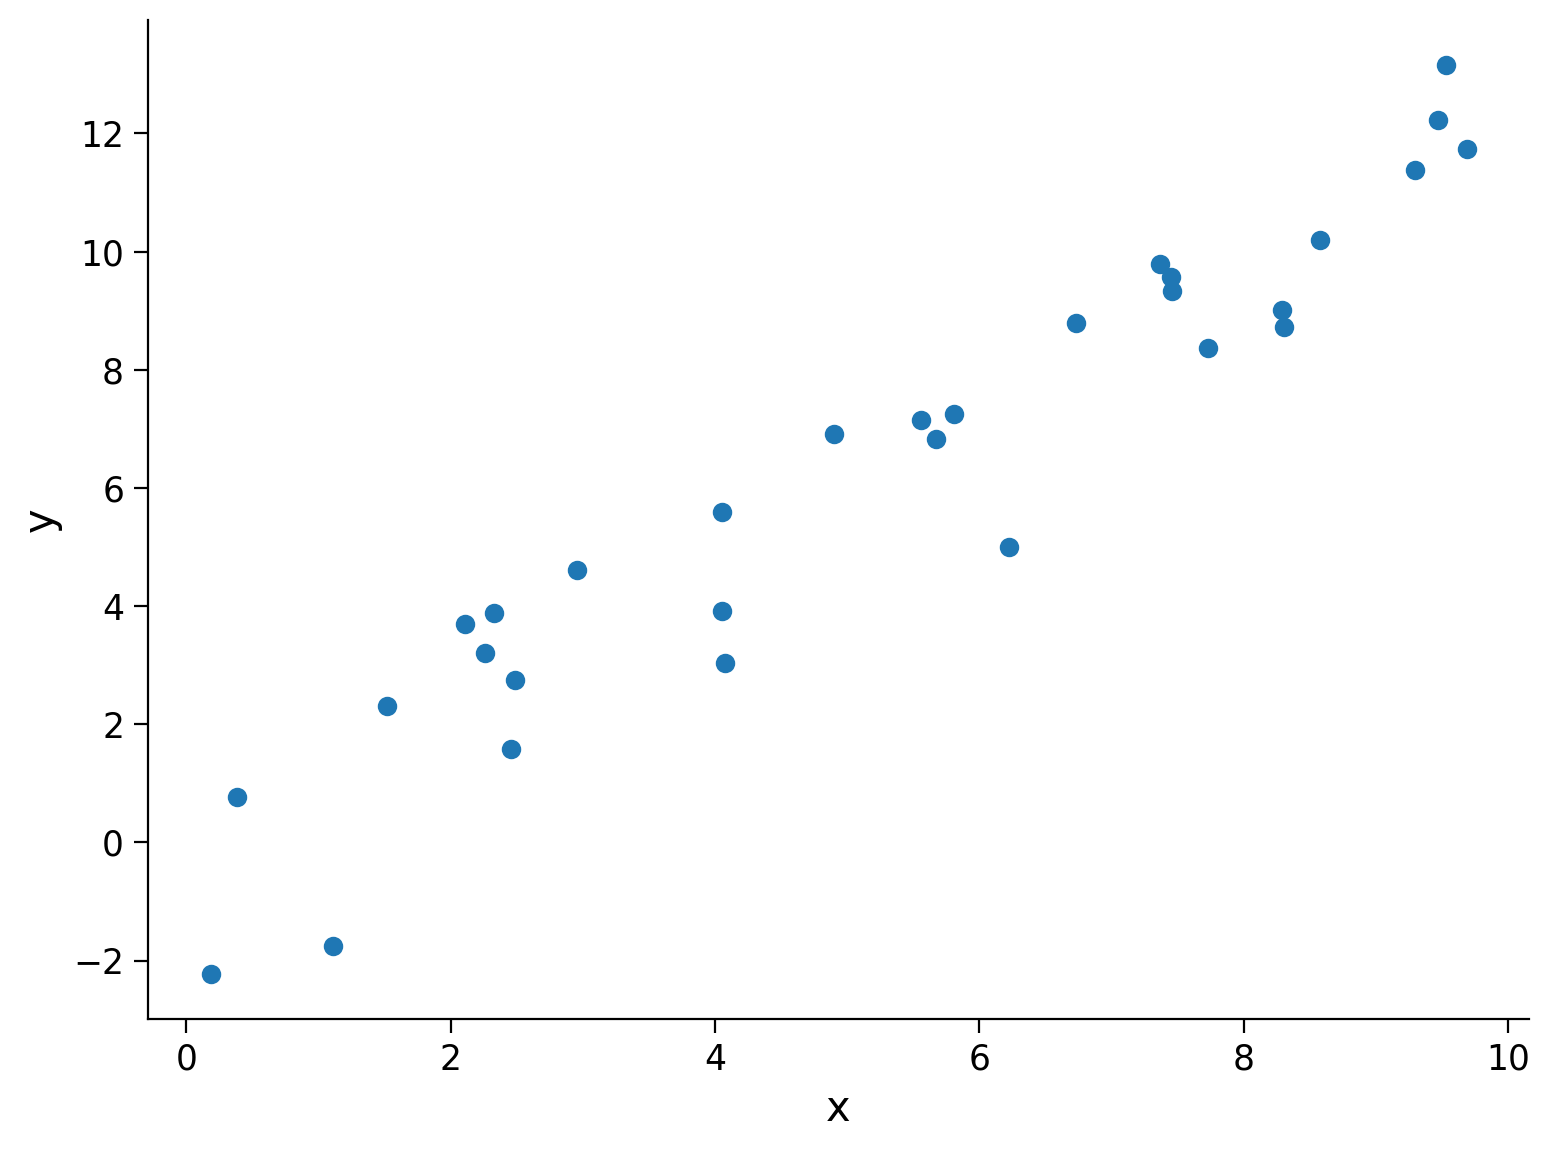

In [ ]:

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 30

# Draw x and then calculate y
x = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * x + noise

# Plot the results
fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

Now that we have our suitably noisy dataset, we can start trying to estimate the underlying model that produced it. We use MSE to evaluate how successful a particular slope estimate $\hat{\theta}$ is for explaining the data, with the closer to 0 the MSE is, the better our estimate fits the data.

## Coding Exercise 1: Compute MSE

In this exercise you will implement a method to compute the mean squared error for a set of inputs $\mathbf{x}$, measurements $\mathbf{y}$, and slope estimate $\hat{\theta}$. Here, $\mathbf{x}$ and $\mathbf{y}$ are vectors of data points. We will then compute and print the mean squared error for 3 different choices of theta.

As a reminder, the equation for computing the estimated y for a single data point is:

\begin{equation}
\hat{y}_{i}= \theta x_{i}
\end{equation}

and for mean squared error is:

\begin{equation}
\min _{\theta} \frac{1}{N}\sum_{i=1}^{N}\left(y_{i}-\hat{y}_i\right)^{2}
\end{equation}

Note this is a slightly different calculation than we saw in class.  How is it different??

In [ ]:
def mse(x, y, theta_hat):
  """Compute the mean squared error

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    theta_hat (float): An estimate of the slope parameter

  Returns:
    float: The mean squared error of the data with the estimated parameter.
  """
  ####################################################
  ## TODO for students: compute the mean squared error
  # Fill out function and remove
  raise NotImplementedError("Student exercise: compute the mean squared error")
  ####################################################

  # Compute the estimated y
  y_hat = ...

  # Compute mean squared error
  mse = ...

  return mse


theta_hats = [0.75, 1.0, 1.5]
for theta_hat in theta_hats:
  print(f"theta_hat of {theta_hat} has an MSE of {mse(x, y, theta_hat):.2f}")

NotImplementedError: Student exercise: compute the mean squared error

The result should be:

```
theta_hat of 0.75 has an MSE of 9.08\
theta_hat of 1.0 has an MSE of 3.0\
theta_hat of 1.5 has an MSE of 4.52
```




We see that $\hat{\theta} = 1.0$ is our best estimate from the three we tried. Looking just at the raw numbers, however, isn't always satisfying, so let's visualize what our estimated model looks like over the data.



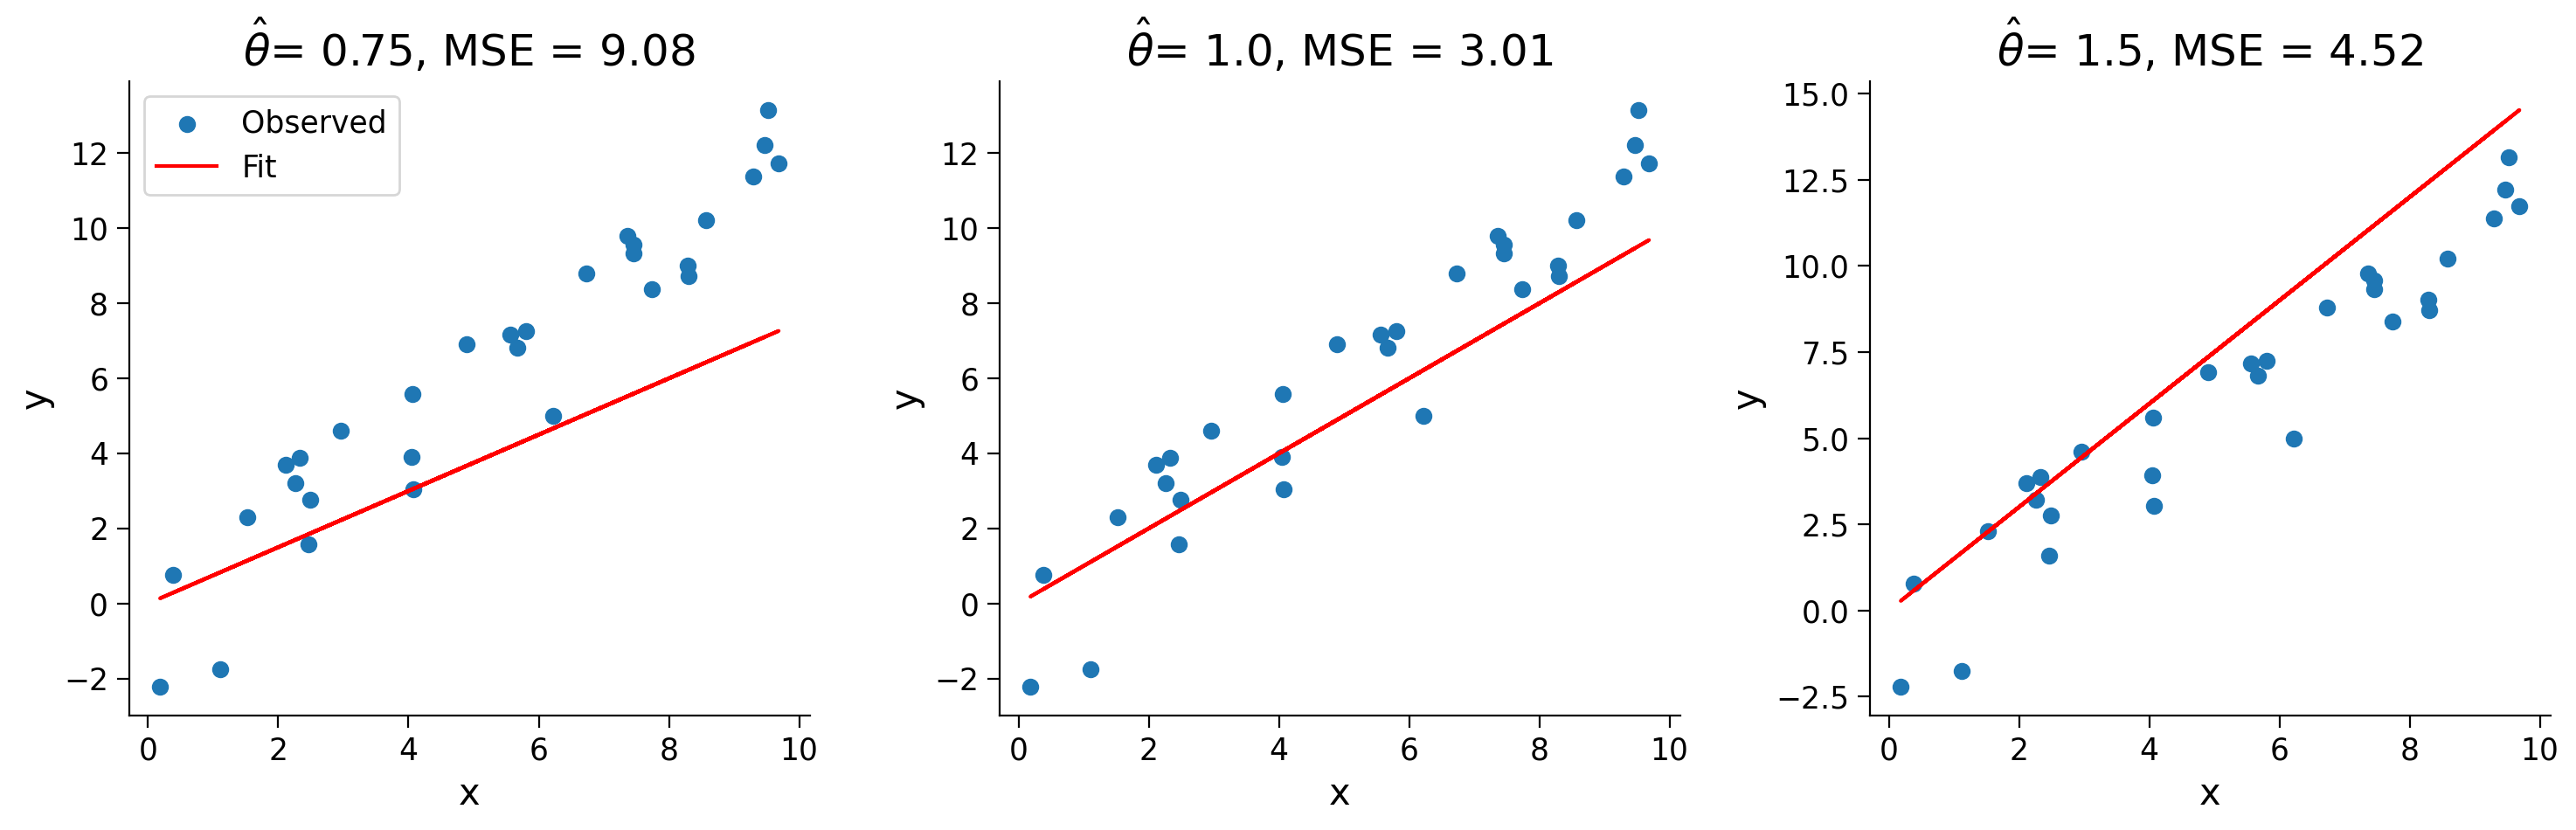

In [ ]:

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for theta_hat, ax in zip(theta_hats, axes):

  # True data
  ax.scatter(x, y, label='Observed')  # our data scatter plot

  # Compute and plot predictions
  y_hat = theta_hat * x
  ax.plot(x, y_hat, color='r', label='Fit')  # our estimated model

  ax.set(
      title= fr'$\hat{{\theta}}$= {theta_hat}, MSE = {np.mean((y - y_hat)**2):.2f}',
      xlabel='x',
      ylabel='y'
  );

axes[0].legend()
plt.show()

## Interactive Demo 1: MSE Explorer

Using an interactive widget, we can easily see how changing our slope estimate changes our model fit. We display the **residuals**, the differences between observed and predicted data, as line segments between the data point (observed response) and the corresponding predicted response on the model fit line.

- What value of $\hat{\theta}$ results in the lowest MSE?
- Is this a good way of estimating $\theta$?


In [ ]:
# @markdown Make sure you execute this cell to enable the widget!
@widgets.interact(theta_hat=widgets.FloatSlider(1.0, min=0.0, max=2.0))
def plot_data_estimate(theta_hat):
  y_hat = theta_hat * x
  plot_observed_vs_predicted(x, y, y_hat, theta_hat)

interactive(children=(FloatSlider(value=1.0, description='theta_hat', max=2.0), Output()), _dom_classes=('widg…

While visually exploring several estimates can be instructive, it's not the most efficient for finding the best estimate to fit our data. Another technique we can use is to choose a reasonable range of parameter values and compute the MSE at several values in that interval. This allows us to plot the error against the parameter value (this is also called an **error landscape**, especially when we deal with more than one parameter). We can select the final $\hat{\theta}$  ($\hat{\theta}_\textrm{MSE}$) as the one which results in the lowest error.

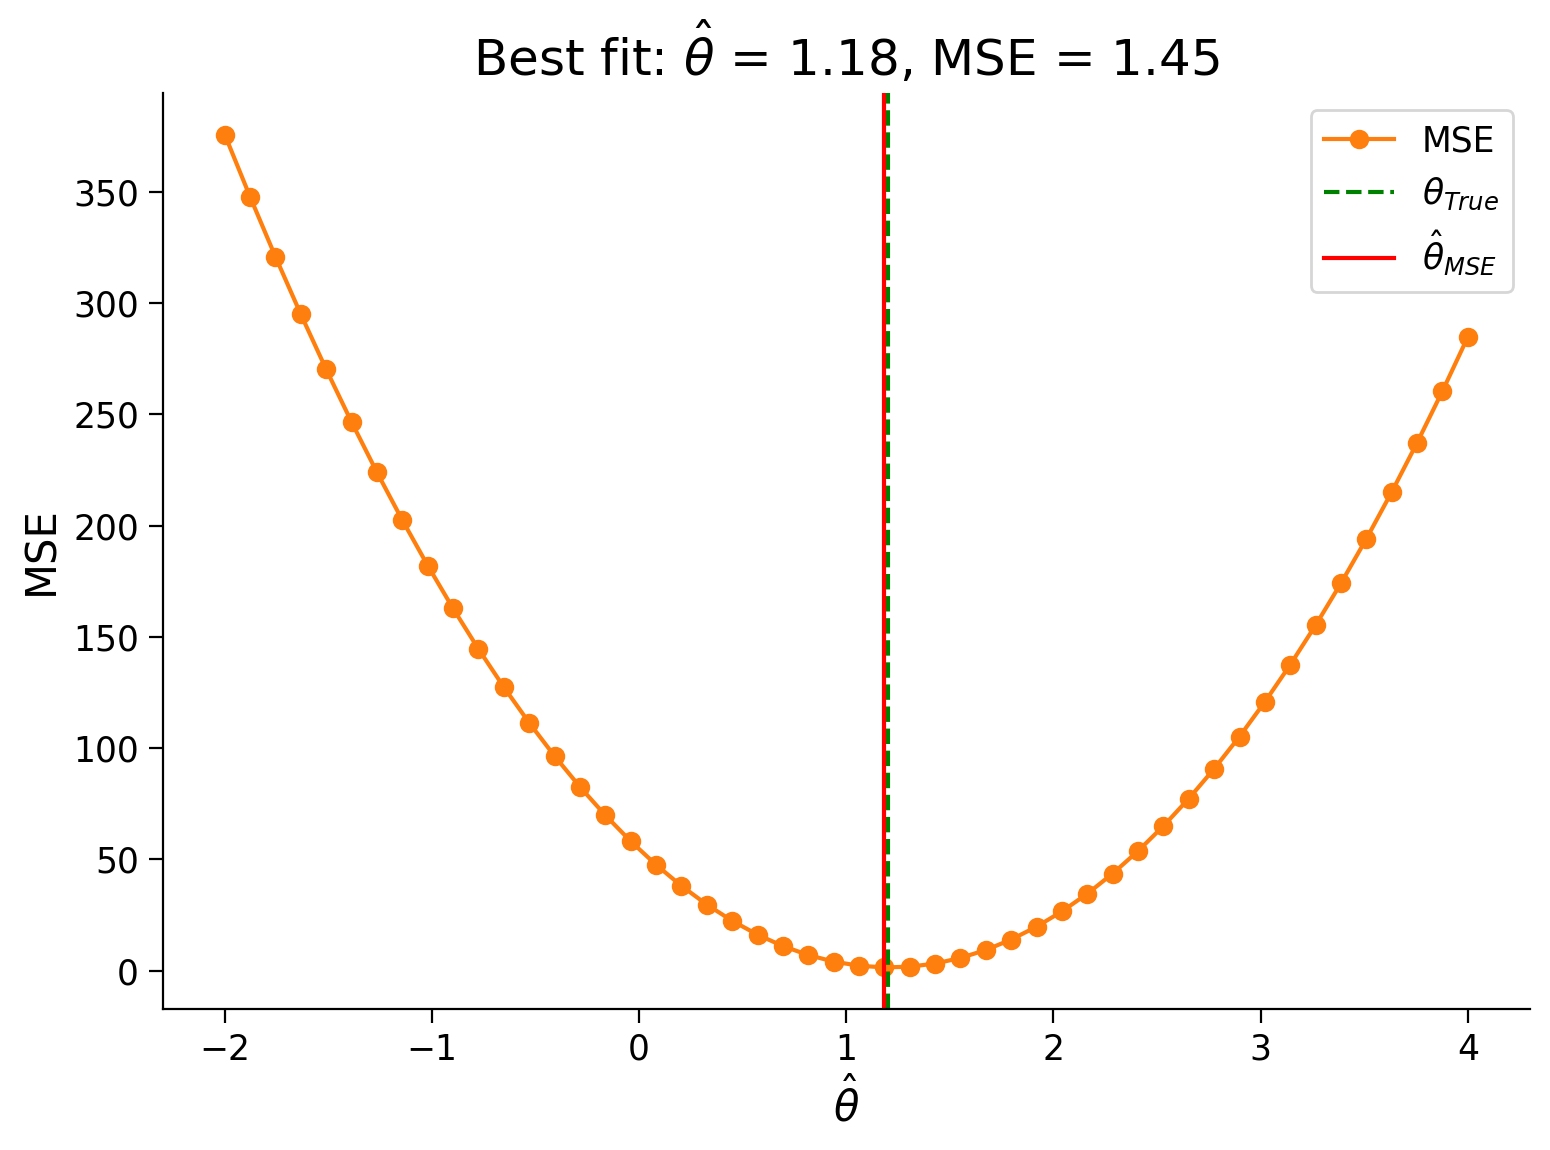

In [ ]:

# Loop over different thetas, compute MSE for each
theta_hat_grid = np.linspace(-2.0, 4.0)
errors = np.zeros(len(theta_hat_grid))
for i, theta_hat in enumerate(theta_hat_grid):
  errors[i] = mse(x, y, theta_hat)

# Find theta that results in lowest error
best_error = np.min(errors)
theta_hat = theta_hat_grid[np.argmin(errors)]


# Plot results
fig, ax = plt.subplots()
ax.plot(theta_hat_grid, errors, '-o', label='MSE', c='C1')
ax.axvline(theta, color='g', ls='--', label=r"$\theta_{True}$")
ax.axvline(theta_hat, color='r', ls='-', label=r"$\hat{{\theta}}_{MSE}$")
ax.set(
  title=fr"Best fit: $\hat{{\theta}}$ = {theta_hat:.2f}, MSE = {best_error:.2f}",
  xlabel=r"$\hat{{\theta}}$",
  ylabel='MSE')
ax.legend()
plt.show()

We can see that our best fit is $\hat{\theta}=1.18$ with an MSE of 1.45. This is quite close to the original true value $\theta=1.2$!


---
# Section 2: Least-squares optimization


While the approach detailed above (computing MSE at various values of $\hat\theta$) quickly got us to a good estimate, it still relied on evaluating the MSE value across a grid of hand-specified values. If we didn't pick a good range to begin with, or with enough granularity, we might miss the best possible estimator. Let's go one step further, and instead of finding the minimum MSE from a set of candidate estimates, let's solve for it analytically.

We can do this by minimizing the cost function. Mean squared error is a convex objective function, therefore we can compute its minimum using calculus (beyond the scope of this class). After computing the minimum, we find that:

\begin{equation}
\hat\theta = \frac{\mathbf{x}^\top \mathbf{y}}{\mathbf{x}^\top \mathbf{x}}
\end{equation}

where $\mathbf{x}$ and $\mathbf{y}$ are vectors of data points.

This is known as solving the normal equations. For different ways of obtaining the solution, see the notes on [Least Squares Optimization](https://www.cns.nyu.edu/~eero/NOTES/leastSquares.pdf) by Eero Simoncelli.

## Coding Exercise 2: Solve for the Optimal Estimator

In this exercise, you will write a function that finds the optimal $\hat{\theta}$ value using the least squares optimization approach (the equation above) to solve MSE minimization. It should take arguments $x$ and $y$ and return the solution $\hat{\theta}$.

We will then use your function to compute $\hat{\theta}$ and plot the resulting prediction on top of the data.

In [ ]:
def solve_normal_eqn(x, y):
  """Solve the normal equations to produce the value of theta_hat that minimizes
    MSE.

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    float: the value for theta_hat arrived from minimizing MSE
  """

  ################################################################################
  ## TODO for students: solve for the best parameter using least squares
  # Fill out function and remove
  raise NotImplementedError("Student exercise: solve for theta_hat using least squares")
  ################################################################################

  # Compute theta_hat analytically
  theta_hat = ...

  return theta_hat


theta_hat = solve_normal_eqn(x, y)
y_hat = theta_hat * x
plot_observed_vs_predicted(x, y, y_hat, theta_hat)

NotImplementedError: Student exercise: solve for theta_hat using least squares

We see that the analytic solution produces an even better result than our grid search from before, producing $\hat{\theta} = 1.21$ with $\text{MSE} = 1.43$!

---
# Interim Summary

Linear least squares regression is an optimization procedure that can be used for data fitting:

  - Task: predict a value for $y_i$ given $x_i$
  - Performance measure: $\textrm{MSE}$
  - Procedure: minimize $\textrm{MSE}$ by solving the normal equations

**Key point**: We fit the model by defining an *objective function* and minimizing it.

**Note**: In this case, there is an *analytical* solution to the minimization problem and in practice, this solution can be computed using *linear algebra*. This is *extremely* powerful and forms the basis for much of numerical computation throughout the sciences.

**Question**: What is another way we can obtain this parameters?  What else did we cover in class??

---
# Section 3: Multiple linear regression and polynomial regression

For this tutorial we will focus on the two-dimensional case ($d=2$), which allows us to easily visualize our results. As an example, think of a situation where a scientist records the spiking response of a retinal ganglion cell to patterns of light signals that vary in contrast and in orientation. Then contrast and orientation values can be used as features / regressors to predict the cells response.

In this case our model can be written for a single data point as:

\begin{equation}
y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \epsilon
\end{equation}

or for multiple data points in matrix form where

\begin{equation}
\mathbf{X} =
\begin{bmatrix}
1 & x_{1,1} & x_{1,2} \\
1 & x_{2,1} & x_{2,2} \\
\vdots & \vdots & \vdots \\
1 & x_{n,1} & x_{n,2}
\end{bmatrix},
\boldsymbol{\theta} =
\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\theta_2 \\
\end{bmatrix}
\end{equation}

When we refer to $x_{i, j}$, we mean that it is the i-th data point and the j-th feature of that data point.

For our actual exploration dataset we shall set $\boldsymbol{\theta}=[0, -2, -3]$ and draw $N=40$ noisy samples from $x \in [-2,2)$. Note that setting the value of $\theta_0 = 0$ effectively ignores the offset term.

## Coding Exercise 3: Ordinary Least Squares Estimator

In this exercise you will implement the OLS approach to estimating $\boldsymbol{\hat\theta}$ from the design matrix $\mathbf{X}$ and measurement vector $\mathbf{y}$. You can use the `@` symbol for matrix multiplication, `.T` for transpose, and `np.linalg.inv` for matrix inversion.


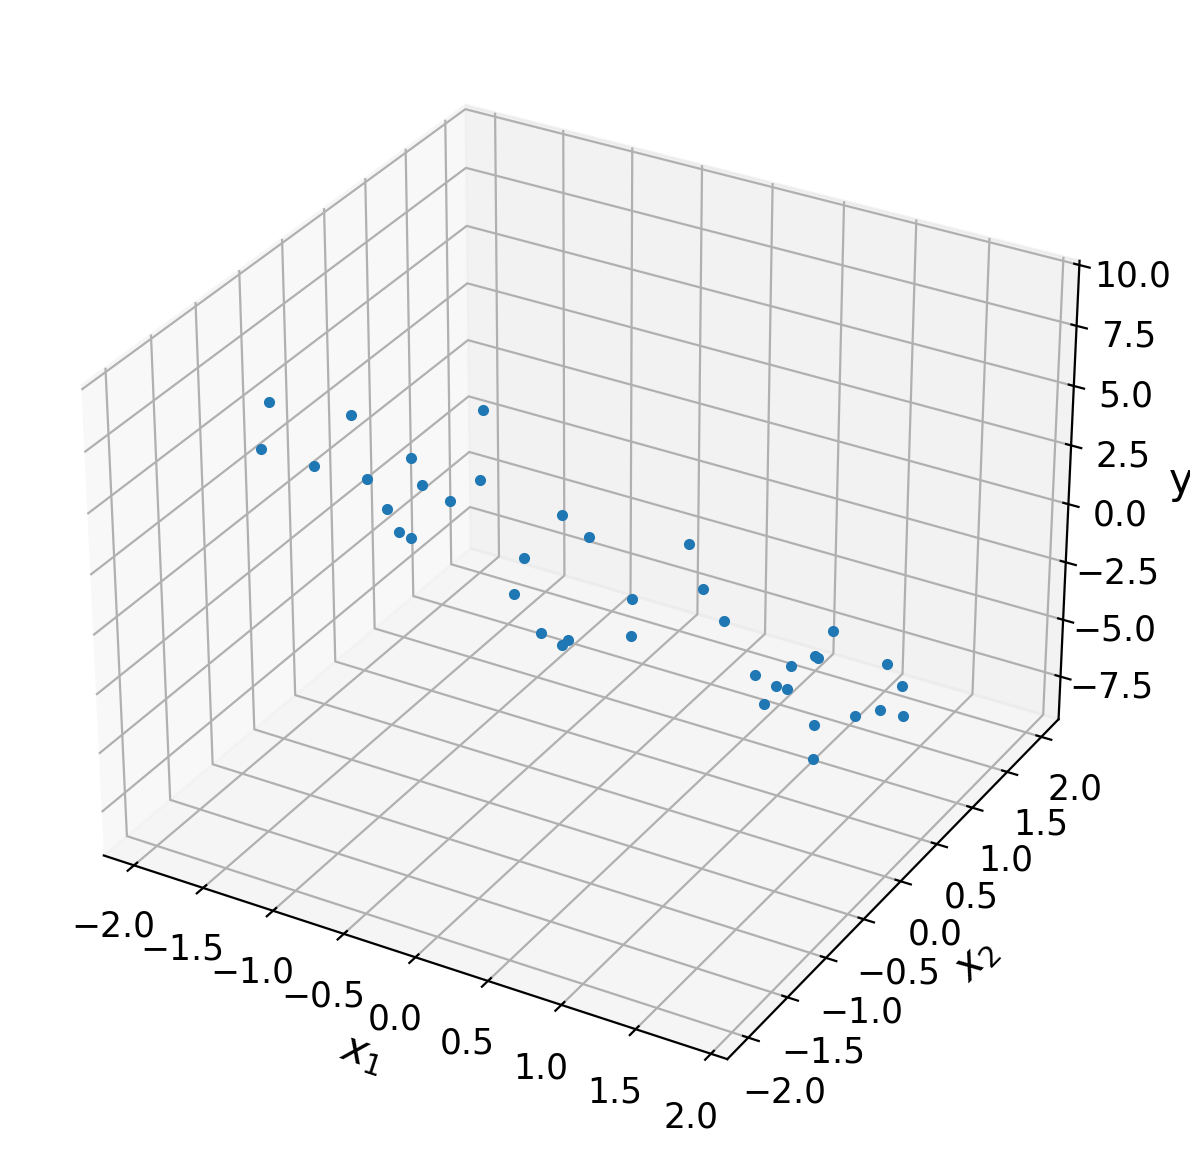

In [ ]:
## Lets simulate some more data:
# Set random seed for reproducibility
np.random.seed(1234)

# Set parameters
theta = [0, -2, -3]
n_samples = 40

# Draw x and calculate y
n_regressors = len(theta)
x0 = np.ones((n_samples, 1))
x1 = np.random.uniform(-2, 2, (n_samples, 1))
x2 = np.random.uniform(-2, 2, (n_samples, 1))
X = np.hstack((x0, x1, x2))
noise = np.random.randn(n_samples)
y = X @ theta + noise


ax = plt.subplot(projection='3d')
ax.plot(X[:,1], X[:,2], y, '.')

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='y'
)
plt.tight_layout()

In [ ]:
def ordinary_least_squares(X, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  ######################################################################
  ## TODO for students: solve for the optimal parameter vector using OLS
  # Fill out function and remove
  raise NotImplementedError("Student exercise: solve for theta_hat vector using OLS")
  ######################################################################

  # Compute theta_hat using OLS
  theta_hat = ...

  return theta_hat


theta_hat = ordinary_least_squares(X, y)
print(theta_hat)

NotImplementedError: Student exercise: solve for theta_hat vector using OLS

Now that we have our $\boldsymbol{\hat\theta}$, we can obtain $\hat{\mathbf{y}}$ and thus our mean squared error.

In [ ]:
# Compute predicted data
theta_hat = ordinary_least_squares(X, y)
y_hat = X @ theta_hat

# Compute MSE
print(f"MSE = {np.mean((y - y_hat)**2):.2f}")

MSE = 0.91


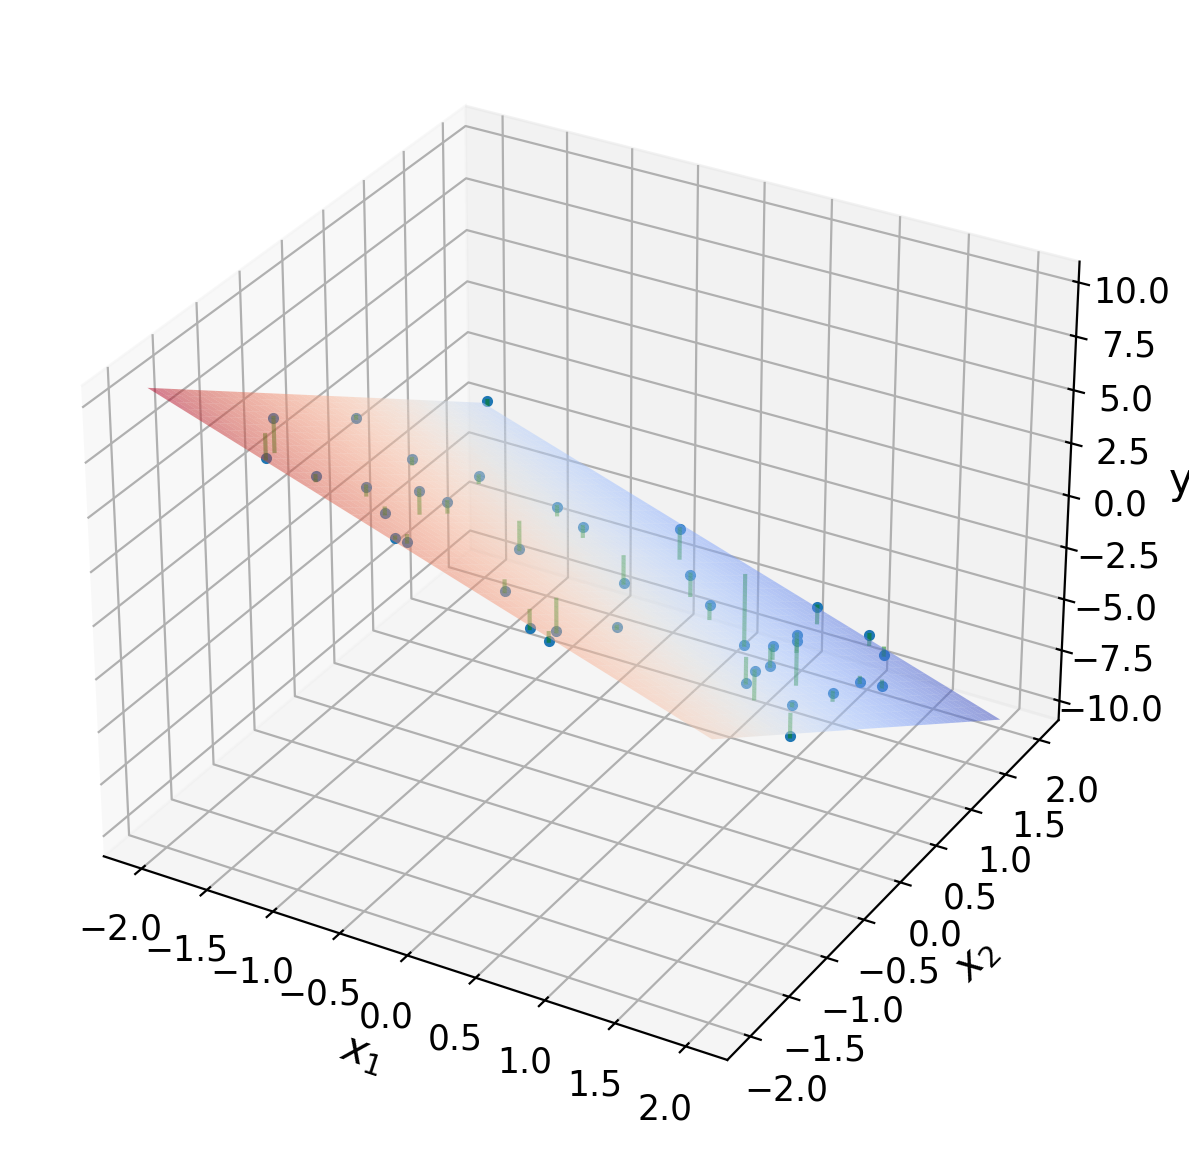

In [ ]:

theta_hat = ordinary_least_squares(X, y)
xx, yy = np.mgrid[-2:2:50j, -2:2:50j]
y_hat_grid = np.array([xx.flatten(), yy.flatten()]).T @ theta_hat[1:]
y_hat_grid = y_hat_grid.reshape((50, 50))

ax = plt.subplot(projection='3d')
ax.plot(X[:, 1], X[:, 2], y, '.')
ax.plot_surface(xx, yy, y_hat_grid, linewidth=0, alpha=0.5, color='C1',
                cmap=plt.get_cmap('coolwarm'))

for i in range(len(X)):
  ax.plot((X[i, 1], X[i, 1]),
          (X[i, 2], X[i, 2]),
          (y[i], y_hat[i]),
          'g-', alpha=.5)

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='y'
)
plt.tight_layout()
plt.show()

---
# Section 4:  Polynomial Regression


So far today, you learned how to predict outputs from inputs by fitting a linear regression model. We can now model all sorts of relationships, including in neuroscience!

One potential problem with this approach is the simplicity of the model. Linear regression, as the name implies, can only capture a linear relationship between the inputs and outputs. Put another way, the predicted outputs are only a weighted sum of the inputs. What if there are more complicated computations happening? Luckily, many more complex models exist (and you will encounter many more over the next 3 weeks). One model that is still very simple to fit and understand, but captures more complex relationships, is **polynomial regression**, an extension of linear regression.


Since polynomial regression is an extension of linear regression, everything you learned so far will come in handy now! The goal is the same: we want to predict the dependent variable $y$ given the input values $x$. The key change is the type of relationship between inputs and outputs that the model can capture.

Linear regression models predict the outputs as a weighted sum of the inputs:

\begin{equation}
y = \theta_0 + \theta x + \epsilon
\end{equation}

With polynomial regression, we model the outputs as a polynomial equation based on the inputs. For example, we can model the outputs as:

\begin{equation}
y = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \epsilon
\end{equation}

We can change how complex a polynomial is fit by changing the order of the polynomial. The order of a polynomial refers to the highest power in the polynomial. The equation above is a third order polynomial because the highest value x is raised to is 3. We could add another term ($+ \theta_4 x^4$) to model an order 4 polynomial and so on.
</details>


First, we will simulate some more data to practice fitting polynomial regression models. We will generate random inputs $x$ and then compute y according to $y = x^2 - x - 2 $, with some extra noise both in the input and the output to make the model fitting exercise closer to a real life situation.

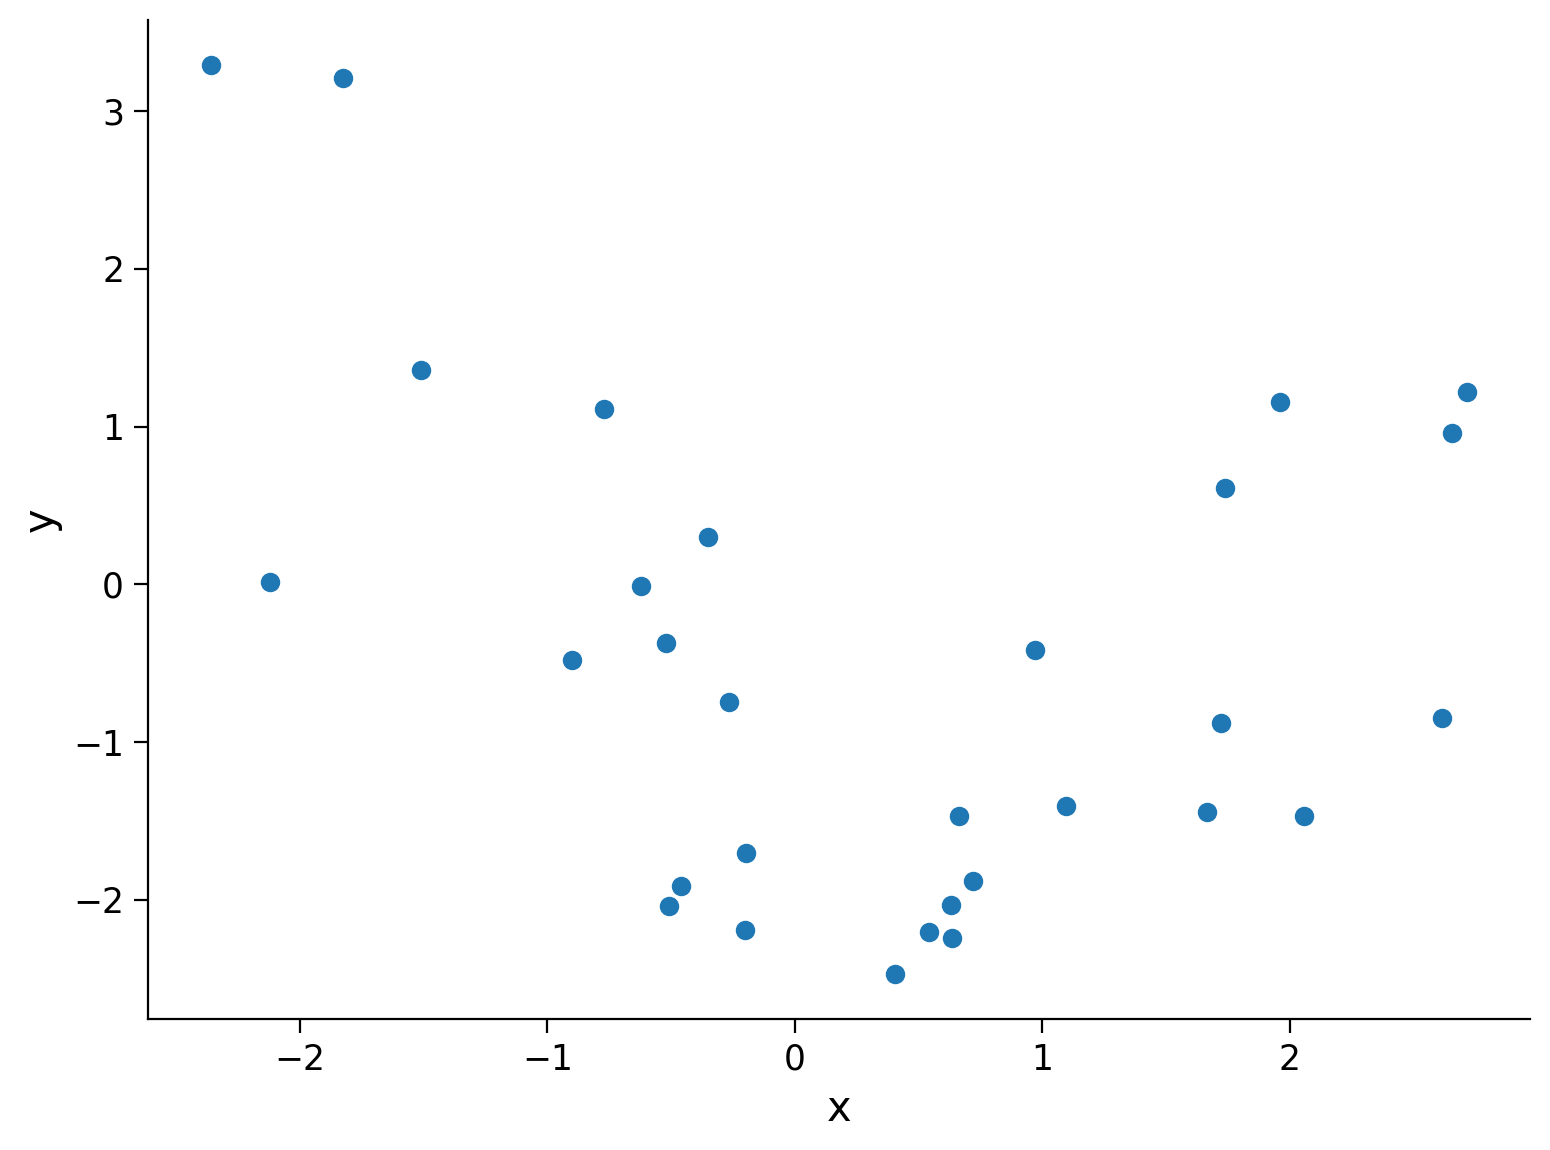

In [ ]:
# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)
n_samples = 30
x = np.random.uniform(-2, 2.5, n_samples)  # inputs uniformly sampled from [-2, 2.5)
y =  x**2 - x - 2   # computing the outputs

output_noise = 1/8 * np.random.randn(n_samples)
y += output_noise  # adding some output noise

input_noise = 1/2 * np.random.randn(n_samples)
x += input_noise  # adding some input noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

## Section 4.1: Design matrix for polynomial regression


Now we have the basic idea of polynomial regression and some noisy data, let's begin! The key difference between fitting a linear regression model and a polynomial regression model lies in how we structure the input variables.

Let's go back to one feature for each data point. For linear regression, we used $\mathbf{X} = \mathbf{x}$ as the input data, where $\mathbf{x}$ is a vector where each element is the input for a single data point. To add a constant bias (a y-intercept in a 2-D plot), we use $\mathbf{X} = \big[ \boldsymbol 1, \mathbf{x} \big]$, where $\boldsymbol 1$ is a column of ones.  When fitting, we learn a weight for each column of this matrix. So we learn a weight that multiples with column 1 - in this case that column is all ones so we gain the bias parameter ($+ \theta_0$).

This matrix $\mathbf{X}$ that we use for our inputs is known as a **design matrix**. We want to create our design matrix so we learn weights for $\mathbf{x}^2, \mathbf{x}^3,$ etc. Thus, we want to build our design matrix $X$ for polynomial regression of order $k$ as:

\begin{equation}
\mathbf{X} = \big[ \boldsymbol 1 , \mathbf{x}^1, \mathbf{x}^2 , \ldots , \mathbf{x}^k \big],
\end{equation}

where $\boldsymbol{1}$ is the vector the same length as $\mathbf{x}$ consisting of of all ones, and $\mathbf{x}^p$ is the vector $\mathbf{x}$ with all elements raised to the power $p$. Note that $\boldsymbol{1} = \mathbf{x}^0$ and $\mathbf{x}^1 = \mathbf{x}$.

If we have inputs with more than one feature, we can use a similar design matrix but include all features raised to each power. Imagine that we have two features per data point: $\mathbf{x}_m$ is a vector of one feature per data point and  $\mathbf{x}_n$ is another.  Our design matrix for a polynomial regression would be:

\begin{equation}
\mathbf{X} = \big[ \boldsymbol 1 , \mathbf{x}_m^1, \mathbf{x}_n^1, \mathbf{x}_m^2 , \mathbf{x}_n^2\ldots , \mathbf{x}_m^k , \mathbf{x}_n^k \big],
\end{equation}

### Coding Exercise 4.1: Structure design matrix

Create a function (`make_design_matrix`) that structures the design matrix given the input data and the order of the polynomial you wish to fit. We will print part of this design matrix for our data and order 5.

In [ ]:
def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression

  Args:
    x (ndarray): input vector of shape (n_samples)
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """
  ########################################################################
  ## TODO for students: create the design matrix ##
  # Fill out function and remove
  raise NotImplementedError("Student exercise: create the design matrix")
  ########################################################################

  # Broadcast to shape (n x 1) so dimensions work
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1))

  # Loop through rest of degrees and stack columns (hint: np.hstack)
  for degree in range(1, order + 1):
      design_matrix = ...

  return design_matrix


order = 5
X_design = make_design_matrix(x, order)

print(X_design[0:2, 0:2])

NotImplementedError: Student exercise: create the design matrix

## Section 4.2: Fitting polynomial regression models


Now that we have the inputs structured correctly in our design matrix, fitting a polynomial regression is the same as fitting a linear regression model! All of the polynomial structure we need to learn is contained in how the inputs are structured in the design matrix. We can use the same least squares solution we computed in previous exercises.

### Coding Exercise 4.2: Fitting polynomial regression models with different orders

Here, we will fit polynomial regression models to find the regression coefficients ($\theta_0, \theta_1, \theta_2,$ ...) by solving the least squares problem. Create a function `solve_poly_reg` that loops over different order polynomials (up to `max_order`), fits that model, and saves out the weights for each. You may invoke the `ordinary_least_squares` function.

We will then qualitatively inspect the quality of our fits for each order by plotting the fitted polynomials on top of the data. In order to see smooth curves, we evaluate the fitted polynomials on a grid of $x$ values (ranging between the largest and smallest of the inputs present in the dataset).

In [ ]:
def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys,
  # and np array of theta_hat (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order + 1):

    ##################################################################################
    ## TODO for students: Create design matrix and fit polynomial model for this order
    # Fill out function and remove
    raise NotImplementedError("Student exercise: fit a polynomial model")
    ##################################################################################

    # Create design matrix
    X_design = ...

    # Fit polynomial model
    this_theta = ...

    theta_hats[order] = this_theta

  return theta_hats


max_order = 5
theta_hats = solve_poly_reg(x, y, max_order)

# Visualize
plot_fitted_polynomials(x, y, theta_hats)

NotImplementedError: Student exercise: fit a polynomial model

## Section 4.3: Evaluating fit quality


As with linear regression, we can compute mean squared error (MSE) to get a sense of how well the model fits the data.

We compute MSE as:

\begin{equation}
\mathrm{MSE} = \frac 1 N ||\mathbf{y} - \hat{\mathbf{y}}||^2 = \frac 1 N \sum_{i=1}^N (y_i - \hat y_i)^2
\end{equation}

where the predicted values for each model are given by $ \hat{\mathbf{y}} = \mathbf{X}\boldsymbol{\hat\theta}$.

*Which model (i.e. which polynomial order) do you think will have the best MSE?*

### Coding Exercise 4.3: Compute MSE and compare models

We will compare the MSE for different polynomial orders with a bar plot.

In [ ]:
mse_list = []
order_list = list(range(max_order + 1))

for order in order_list:

  X_design = make_design_matrix(x, order)

  ########################################################################
  ## TODO for students
  # Fill out function and remove
  raise NotImplementedError("Student exercise: compute MSE")
  ########################################################################

  # Get prediction for the polynomial regression model of this order
  y_hat = ...

  # Compute the residuals
  residuals = ...

  # Compute the MSE
  mse = ...

  mse_list.append(mse)


# Visualize MSE of fits
evaluate_fits(order_list, mse_list)

NotImplementedError: Student exercise: compute MSE

---
# Interim Summary

* Linear regression generalizes naturally to multiple dimensions
* Linear algebra affords us the mathematical tools to reason and solve such problems beyond the two dimensional case

* To change from a linear regression model to a polynomial regression model, we only have to change how the input data is structured

* We can choose the complexity of the model by changing the order of the polynomial model fit

* Higher order polynomial models tend to have lower MSE on the data they're fit with

---
# Section 5: Train vs test data

 The data used for the fitting procedure for a given model is the **training data**. In tutorial 4, we computed MSE on the training data of our polynomial regression models and compared training MSE across models. An additional important type of data is **test data**. This is held-out data that is not used (in any way) during the fitting procedure. When fitting models, we often want to consider both the train error (the quality of prediction on the training data) and the test error (the quality of prediction on the test data) as we will see in the next section.

We will generate some noisy data for use in this tutorial using a similar process as in Section 4. However, now we will also generate test data. We want to see how our model generalizes beyond the range of values seen in the training phase. To accomplish this, we will generate x from a wider range of values ([-3, 3]). We then plot the train and test data together.

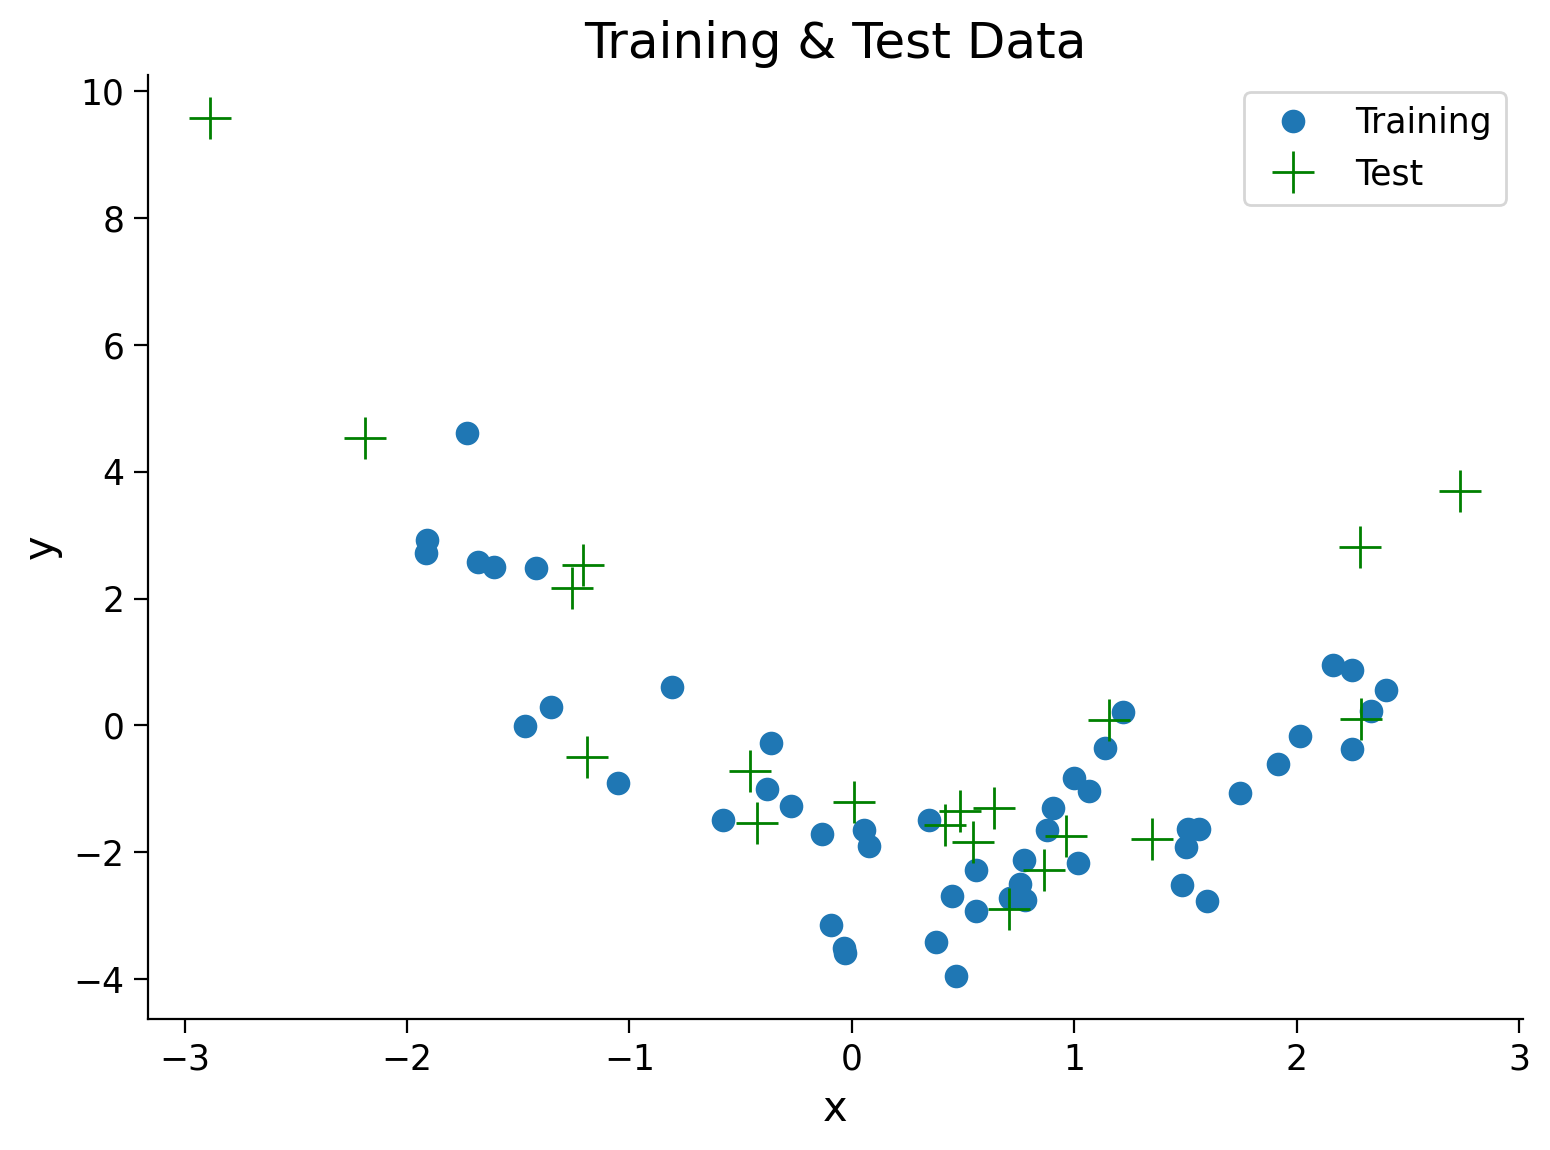

In [ ]:

### Generate training data
np.random.seed(0)
n_train_samples = 50
x_train = np.random.uniform(-2, 2.5, n_train_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_train_samples) # sample from a standard normal distribution
y_train =  x_train**2 - x_train - 2 + noise

### Generate testing data
n_test_samples = 20
x_test = np.random.uniform(-3, 3, n_test_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_test_samples) # sample from a standard normal distribution
y_test =  x_test**2 - x_test - 2 + noise

## Plot both train and test data
fig, ax = plt.subplots()
plt.title('Training & Test Data')
plt.plot(x_train, y_train, '.', markersize=15, label='Training')
plt.plot(x_test, y_test, 'g+', markersize=15, label='Test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

---
# Section 5: Bias-variance tradeoff


Finding a good model can be difficult. One of the most important concepts to keep in mind when modeling is the **bias-variance tradeoff**.

**Bias** is the difference between the prediction of the model and the corresponding true output variables you are trying to predict. Models with high bias will not fit the training data well since the predictions are quite different from the true data. These high bias models are overly simplified - they do not have enough parameters and complexity to accurately capture the patterns in the data and are thus **underfitting**.


**Variance** refers to the variability of model predictions for a given input. Essentially, do the model predictions change a lot with changes in the exact training data used? Models with high variance are highly dependent on the exact training data used - they will not generalize well to test data. These high variance models are **overfitting** to the data.

In essence:

* High bias, low variance models have high train and test error.
* Low bias, high variance models have low train error, high test error
* Low bias, low variance models have low train and test error


As we can see from this list, we ideally want low bias and low variance models! These goals can be in conflict though - models with enough complexity to have low bias also tend to overfit and depend on the training data more. We need to decide on the correct tradeoff.

In this section, we will see the bias-variance tradeoff in action with polynomial regression models of different orders.

</details>

Graphical illustration of bias and variance.
(Source: http://scott.fortmann-roe.com/docs/BiasVariance.html)

![bias-variance](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/images/bias_variance/bullseye.png)

We will first fit polynomial regression models of orders 0-5 on our simulated training data just as we did in Section 4.

In [ ]:
max_order = 5
theta_hats = solve_poly_reg(x_train, y_train, max_order)

## Coding Exercise 5.1: Compute and compare train vs test error

We will use MSE as our error metric again. Compute MSE on training data ($x_{train},y_{train}$) and test data ($x_{test}, y_{test}$) for each polynomial regression model (orders 0-5). Since you already developed code in T4 Exercise 4 for making design matrices and evaluating fit polynomials, we have ported that here into the functions `make_design_matrix` and `evaluate_poly_reg` for your use.

*Please think about it after completing the exercise before reading the following text! Do you think the order 0 model has high or low bias? High or low variance? How about the order 5 model?*

In [ ]:
def evaluate_poly_reg(x, y, theta_hats, max_order):
  """ Evaluates MSE of polynomial regression models on data

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    theta_hats (dict):  fitted weights for each polynomial model (dict key is order)
    max_order (scalar): max order of polynomial fit

  Returns
    (ndarray): mean squared error for each order, shape (max_order)
  """

  mse = np.zeros((max_order + 1))
  for order in range(0, max_order + 1):
    X_design = make_design_matrix(x, order)
    y_hat = np.dot(X_design, theta_hats[order])
    residuals = y - y_hat
    mse[order] = np.mean(residuals ** 2)

  return mse

In [ ]:
def compute_mse(x_train, x_test, y_train, y_test, theta_hats, max_order):
  """Compute MSE on training data and test data.

  Args:
    x_train(ndarray): training data input vector of shape (n_samples)
    x_test(ndarray): test data input vector of shape (n_samples)
    y_train(ndarray): training vector of measurements of shape (n_samples)
    y_test(ndarray): test vector of measurements of shape (n_samples)
    theta_hats(dict): fitted weights for each polynomial model (dict key is order)
    max_order (scalar): max order of polynomial fit

  Returns:
    ndarray, ndarray: MSE error on training data and test data for each order
  """

  #######################################################
  ## TODO for students: calculate mse error for both sets
  ## Hint: look back at tutorial 5 where we calculated MSE
  # Fill out function and remove
  raise NotImplementedError("Student exercise: calculate mse for train and test set")
  #######################################################

  mse_train = ...
  mse_test = ...

  return mse_train, mse_test


# Compute train and test MSE
mse_train, mse_test = compute_mse(x_train, x_test, y_train, y_test, theta_hats, max_order)

# Visualize
plot_MSE_poly_fits(mse_train, mse_test, max_order)

As we can see from the plot above, more complex models (higher order polynomials) have lower MSE for training data. The overly simplified models (orders 0 and 1) have high MSE on the training data. As we add complexity to the model, we go from high bias to low bias.

The MSE on test data follows a different pattern. The best test MSE is for an order 2 model - this makes sense as the data was generated with an order 2 model. Both simpler models and more complex models have higher test MSE.

So to recap:

Order 0 model: High bias, low variance

Order 5 model: Low bias, high variance

Order 2 model: Just right, low bias, low variance

---
# Interim Summary

- Training data is the data used for fitting, test data is held-out data.
- We need to strike the right balance between bias and variance. Ideally we want to find a model with optimal model complexity that has both low bias and low variance
 - Too complex models have low bias and high variance.
 - Too simple models have high bias and low variance.

---
# Section 6: Cross-validation

We now have multiple choices for which model to use for a given problem: we could use linear regression, order 2 polynomial regression, order 3 polynomial regression, etc. As we saw in Tutorial 5, different models will have different quality of predictions, both on the training data and on the test data.

A commonly used method for model selection is to ask how well the model predicts new data that it hasn't seen yet. But we don't want to use test data to do this, otherwise that would mean using it during the training process! One approach is to use another kind of held-out data which we call **validation data**: we do not fit the model with this data but we use it to select our best model.

We often have a limited amount of data though (especially in neuroscience), so we do not want to further reduce our potential training data by reassigning some as validation. Luckily, we can use **k-fold cross-validation**! In k-fold cross validation, we divide up the training data into k subsets (that are called *folds*, see diagram below), train our model on the first k-1 folds, and then compute error on the last held-out fold. We can then repeat this process k times, once on each k-1 folds of the data. Each of these k instances (which are called *splits*, see diagram below) excludes a different fold from fitting. We then average the error of each of the k trained models on its held-out subset - this is the final measure of performance which we can use to do model selection.

To make this explicit, let's say we have 1000 samples of training data and choose 4-fold cross-validation. Samples 0 - 250 would be subset 1, samples 250 - 500 subset 2, samples 500 - 750 subset 3, and samples 750-1000 subset 4. First, we train an order 3 polynomial regression on subsets 1, 2, 3 and evaluate on subset 4. Next, we train an order 3 polynomial model on subsets 1, 2, 4 and evaluate on subset 3. We continue until we have 4 instances of a trained order 3 polynomial regression model, each with a different subset as held-out data, and average the held-out error from each instance.

We can now compare the error of different models to pick a model that generalizes well to held-out data. We can choose the measure of prediction quality to report error on the held-out subsets to suit our purposes. We will use MSE here but we could also use log likelihood of the data and so on.

As a final step, it is common to retrain this model on all of the training data (without subset divisions) to get our final model that we will evaluate on test data. This approach allows us to evaluate the quality of predictions on new data without sacrificing any of our precious training data.

Note that the held-out subsets are called either validation or test subsets. There is not a consensus and may depend on the exact use of k-fold cross validation. Sometimes people use k-fold cross validation to choose between different models/parameters to then apply to held-out test data and sometimes people report the averaged error on the held-out subsets as the model performance.   If you are doing the former (using k-fold cross validation for model selection), you must report performance on held-out test data! In this text/code, we will refer to them as validation subsets to differentiate from our completely held-out test data (differing from the video above).


These steps are summarized in this diagram from Scikit-learn (https://scikit-learn.org/stable/modules/cross_validation.html)

![Diagram from Sklearn](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

Importantly, we need to be very careful when dividing the data into subsets.  The held-out subset should not be used in any way to fit the model. We should not do any preprocessing (e.g. normalization) before we divide into subsets or the held-out subset could influence the training subsets. A lot of false-positives in cross-validation come from wrongly dividing.

An important consideration in the choice of model selection method are the relevant biases. If we just fit using MSE on training data, we will generally find that fits get better as we add more parameters because the model will overfit the data, as we saw in Tutorial 5. When using cross-validation, the bias is the other way around. Models with more parameters are more affected by variance so cross-validation will generally prefer models with fewer parameters.

In [ ]:

# Generate training data
np.random.seed(0)
n_train_samples = 50
x_train = np.random.uniform(-2, 2.5, n_train_samples)  # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_train_samples)  # sample from a standard normal distribution
y_train = x_train**2 - x_train - 2 + noise

# Generate testing data
n_test_samples = 20
x_test = np.random.uniform(-3, 3, n_test_samples)  # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_test_samples)  # sample from a standard normal distribution
y_test = x_test**2 - x_test - 2 + noise

# Fit polynomial regression models
max_order = 5
theta_hats = solve_poly_reg(x_train, y_train, max_order)

## Coding Exercise 6.1: Implement cross-validation

Given our set of models to evaluate (polynomial regression models with orders 0 through 5), we will use cross-validation to determine which model has the best predictions on new data according to MSE.

In this code, we split the data into 10 subsets using `Kfold` (from `sklearn.model_selection`). `KFold` handles cross-validation subset splitting and train/val assignments.  In particular, the `Kfold.split` method returns an iterator which we can loop through. On each loop, this iterator assigns a different subset as validation and returns new training and validation indices with which to split the data.

We will loop through the 10 train/validation splits and fit several different polynomial regression models (with different orders) for each split. You will need to use the `solve_poly_reg` method from Tutorial 4 and `evaluate_poly_reg` from Tutorial 5 (already implemented in this notebook).

We will visualize the validation MSE over 10 splits of the data for each polynomial order using box plots.

In [ ]:
help(solve_poly_reg)

Help on function solve_poly_reg in module __main__:

solve_poly_reg(x, y, max_order)
    Fit a polynomial regression model for each order 0 through max_order.
    
    Args:
      x (ndarray): input vector of shape (n_samples)
      y (ndarray): vector of measurements of shape (n_samples)
      max_order (scalar): max order for polynomial fits
    
    Returns:
      dict: fitted weights for each polynomial model (dict key is order)



In [ ]:
help(evaluate_poly_reg)

Help on function evaluate_poly_reg in module __main__:

evaluate_poly_reg(x, y, theta_hats, max_order)
    Evaluates MSE of polynomial regression models on data
    
    Args:
      x (ndarray): input vector of shape (n_samples)
      y (ndarray): vector of measurements of shape (n_samples)
      theta_hats (dict):  fitted weights for each polynomial model (dict key is order)
      max_order (scalar): max order of polynomial fit
    
    Returns
      (ndarray): mean squared error for each order, shape (max_order)



In [ ]:
def cross_validate(x_train, y_train, max_order, n_splits):
  """ Compute MSE for k-fold validation for each order polynomial

  Args:
    x_train (ndarray): training data input vector of shape (n_samples)
    y_train (ndarray): training vector of measurements of shape (n_samples)
    max_order (scalar): max order of polynomial fit
    n_split (scalar): number of folds for k-fold validation

  Return:
    ndarray: MSE over splits for each model order, shape (n_splits, max_order + 1)

  """

  # Initialize the split method
  kfold_iterator = KFold(n_splits)

  # Initialize np array mse values for all models for each split
  mse_all = np.zeros((n_splits, max_order + 1))

  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(x_train)):

      # Split up the overall training data into cross-validation training and validation sets
      x_cv_train = x_train[train_indices]
      y_cv_train = y_train[train_indices]
      x_cv_val = x_train[val_indices]
      y_cv_val = y_train[val_indices]

      #############################################################################
      ## TODO for students: Fill in missing ... in code below to choose which data
      ## to fit to and compute MSE for
      # Fill out function and remove
      raise NotImplementedError("Student exercise: implement cross-validation")
      #############################################################################

      # Fit models
      theta_hats = ...

      # Compute MSE
      mse_this_split = ...

      mse_all[i_split] = mse_this_split

  return mse_all


# Cross-validate
max_order = 5
n_splits = 10
mse_all = cross_validate(x_train, y_train, max_order, n_splits)

# Visualize
plot_cross_validate_MSE(mse_all)

<ipython-input-39-06392b8033d8>:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mse_all, labels=np.arange(0, max_order + 1))


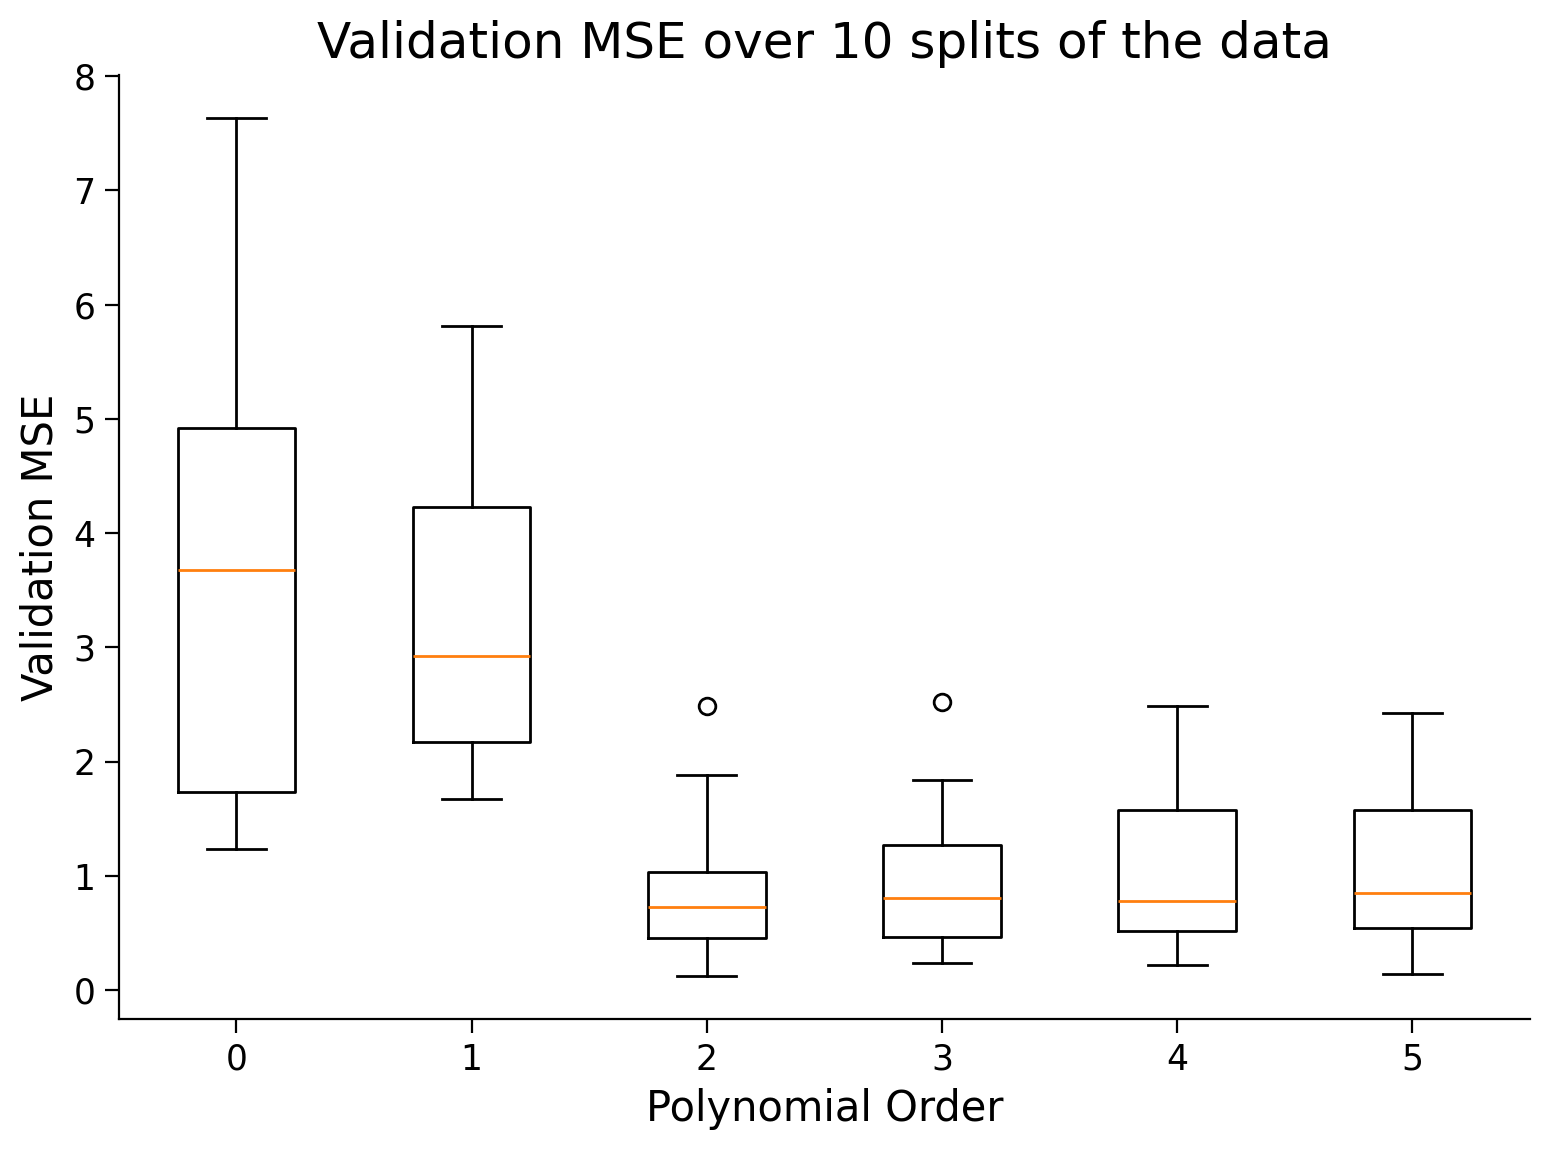

In [ ]:
def cross_validate(x_train, y_train, max_order, n_splits):
  """ Compute MSE for k-fold validation for each order polynomial

  Args:
    x_train (ndarray): training data input vector of shape (n_samples)
    y_train (ndarray): training vector of measurements of shape (n_samples)
    max_order (scalar): max order of polynomial fit
    n_split (scalar): number of folds for k-fold validation

  Return:
    ndarray: MSE over splits for each model order, shape (n_splits, max_order + 1)

  """

  # Initialize the split method
  kfold_iterator = KFold(n_splits)

  # Initialize np array mse values for all models for each split
  mse_all = np.zeros((n_splits, max_order + 1))

  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(x_train)):

      # Split up the overall training data into cross-validation training and validation sets
      x_cv_train = x_train[train_indices]
      y_cv_train = y_train[train_indices]
      x_cv_val = x_train[val_indices]
      y_cv_val = y_train[val_indices]

      #############################################################################
      ## TODO for students: Fill in missing ... in code below to choose which data
      ## to fit to and compute MSE for
      # Fill out function and remove
      # raise NotImplementedError("Student exercise: implement cross-validation")
      #############################################################################

      # Fit models
      theta_hats = solve_poly_reg(x_cv_train, y_cv_train, max_order)

      # Compute MSE
      mse_this_split = evaluate_poly_reg(x_cv_val, y_cv_val, theta_hats, max_order)


      mse_all[i_split] = mse_this_split

  return mse_all


# Cross-validate
max_order = 5
n_splits = 10
mse_all = cross_validate(x_train, y_train, max_order, n_splits)

# Visualize
plot_cross_validate_MSE(mse_all)

Which polynomial order do you think is a better model of the data?

---
# Interim Summary

We need to use model selection methods to determine the best model to use for a given problem.

Cross-validation focuses on how well the model predicts new data.

---
# Section 7: `Sklearn`

In [51]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

Let's start by replicating the first linear regression analysis (Sections 1 and 2) using `sklearn` and cross validation. First let's create that same set of fake data.

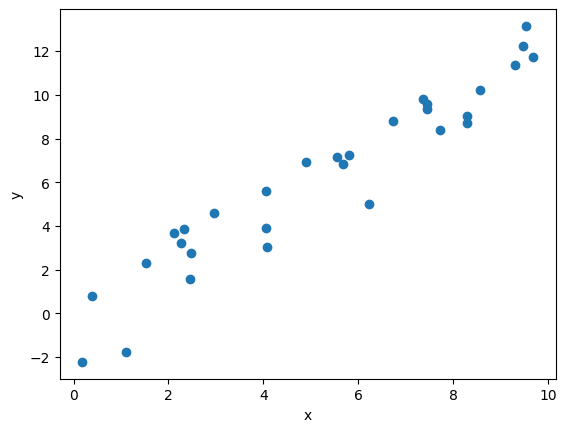

In [35]:
# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 30

# Draw x and then calculate y
X = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * X + noise

X = X[:, np.newaxis]

# Plot the results
fig, ax = plt.subplots()
ax.scatter(X, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

Prepare the data using `train_test_split`.

In [36]:
X_train, X_cv_test, y_train, y_cv_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's first just run the same linear regression model. First we fit the model to the training data.

In [37]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Then we make predictions on the test (cross validation) set.

In [41]:
y_pred = model.predict(X_cv_test)

And then we calculate the Mean Squared Error

In [42]:
mse = mean_squared_error(y_cv_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.2140527987318623


We can get the theta value using `.coef_`.

In [43]:
model.coef_

array([1.30519074])

Pretty close to what we had before!  Ok now lets move on to the polynomial regression data.

In [44]:
# Generate training data
np.random.seed(0)
n_train_samples = 100
X = np.random.uniform(-2, 2.5, n_train_samples)  # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_train_samples)  # sample from a standard normal distribution
y = X**2 - X - 2 + noise
X = X[:, np.newaxis]

# Generate testing data
n_test_samples = 20
X_generalization_test = np.random.uniform(-3, 3, n_test_samples)  # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_test_samples)  # sample from a standard normal distribution
y_generalization_test = X_generalization_test**2 - X_generalization_test - 2 + noise


Let's plot it all just to see what we've got! Notice that we haven't split the `X` and `y` into the train and cross validation set yet.  We'll do that in the function below.

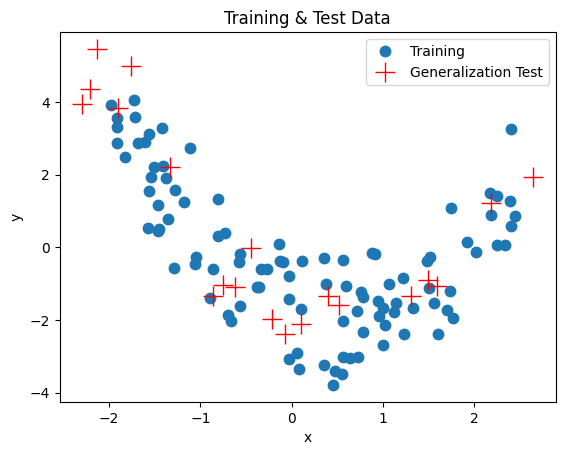

In [48]:
## Plot both train and test data
fig, ax = plt.subplots()
plt.title('Training & Test Data')
plt.plot(X, y, '.', markersize=15, label='Training')
plt.plot(X_generalization_test, y_generalization_test, 'r+', markersize=15, label='Generalization Test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

Let's define this function to make things easier.  We're going to now split the `X` and `y` data into the training and cross validation test data and we'll do this for several folds just like the implementation above.  

In [49]:
def polynomial_regression_cv(X, y, degree, k_folds=5):
    """
    Performs polynomial regression with k-fold cross-validation.

    Args:
        X (array-like): Input features.
        y (array-like): Target values.
        degree (int): Degree of the polynomial.
        k_folds (int, optional): Number of folds for cross-validation. Defaults to 5.

    Returns:
        float: Mean cross-validated mean squared error.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train.reshape(-1, 1))
        X_test_poly = poly.transform(X_test.reshape(-1, 1))

        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        y_pred = model.predict(X_test_poly)

        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

    return np.mean(mse_scores)



In [53]:
degrees = [0, 1, 2, 3, 4, 5]
for degree in degrees:
    mse = polynomial_regression_cv(X, y, degree)
    print(f"Mean MSE for degree {degree}: {mse}")

Mean MSE for degree 0: 3.7784835578967146
Mean MSE for degree 1: 3.3019239742968134
Mean MSE for degree 2: 1.0414061661705674
Mean MSE for degree 3: 1.0608073508930531
Mean MSE for degree 4: 1.0830206829330367
Mean MSE for degree 5: 1.121695459507361
